In [1]:
import pandas as pd
import numpy as np
import os
import torch
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import r2_score

from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
pd.options.display.max_columns = None


In [2]:
def get_player_stats_by_id_or_name(df, input):
    player_field = "age,games,minutes,overall,potential,pace,shooting,passing,dribbling,defending,physic,DF,FW,GK,MF,pos_avg".rsplit(',')
    if type(input) == int:
        return df[df.id == input][player_field].to_numpy()[0]
    elif type(input) == str:
        return df[df.player == input][player_field].to_numpy()[0]
def get_player_team_vector(df, player_input, team_input):
    teams_list = ['TEAM Athletic Club', 'TEAM Atlético de Madrid', 'TEAM CA Osasuna',
       'TEAM Cádiz CF', 'TEAM Deportivo Alavés', 'TEAM Elche CF',
       'TEAM FC Barcelona', 'TEAM Getafe CF', 'TEAM Granada CF',
       'TEAM Levante UD', 'TEAM RC Celta de Vigo', 'TEAM RCD Espanyol',
       'TEAM RCD Mallorca', 'TEAM Rayo Vallecano', 'TEAM Real Betis Balompié',
       'TEAM Real Madrid CF', 'TEAM Real Sociedad', 'TEAM Sevilla FC',
       'TEAM Valencia CF', 'TEAM Villarreal CF']
    if type(team_input) == str:
        team_ohe_vector = [1 if team_input.lower() in team.lower() else 0 for team in teams_list]
        if np.sum(team_ohe_vector) < 1:
            return "team not found in the dataset"
        elif np.sum(team_ohe_vector) > 1:
            return "team input need to be more precise"
    
    player_stat = get_player_stats_by_id_or_name(df, player_input)
    return np.concatenate([player_stat, team_ohe_vector], axis = 0) 

# get_player_stats_by_id_or_name(df, 'Gerard Piqué')
# get_player_team_vector(df, 'Gerard Piqué', 'Real Madrid').shape

In [3]:
df = pd.read_csv('df.csv', sep=',', encoding='utf8', engine="python", index_col=0, parse_dates = False)
df.value_eur = np.log(df.value_eur)
df.pass_targets = np.sqrt(df.pass_targets)
df

,season,player,squad,age,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_defense,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_defense,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_subs,minutes_per_sub,unused_subs,points_per_match,on_goals_for,on_goals_against,plus_minus,plus_minus_per90,plus_minus_wowy,on_xg_for,on_xg_against,xg_plus_minus,xg_plus_minus_per90,xg_plus_minus_wowy,wc_starts,wc_games,wc_minutes,wc_goals,wc_assists,wc_cards_yellow,wc_cards_red,value_eur,GK,MF,DF,FW,started_ratio,dribbles_completed_diff,pass_completed_short_ratio,pass_completed_medium_ratio,rich_team,best_age
0,2022,Aaron Connolly,Brighton & Hove Albion,21,45.0,24.0,2205.0,5.0,2.0,0.0,0.0,0.0,0.0,0.44,0.18,0.63,0.44,0.63,7.2,7.2,0.9,0.89,0.24,1.14,0.89,1.14,24.5,63.0,21.0,0.0,69.0,6.49,1.84,0.17,0.48,0.46,-2.2,-2.2,220.0,282.0,238.8,3098.0,417.0,130.0,159.0,244.8,63.0,76.0,251.9,11.0,16.0,143.6,1.100000e+00,12.0,8.0,3.0,0.0,13.0,256.0,26.0,0.0,1.0,78.0,1.0,10.0,0.0,0.0,0.0,0.0,169.0,81.0,32.0,39.0,196.0,18.0,1.0,11.0,0.0,1.0,7.0,15.0,39.0,4.31,16.0,0.0,6.0,3.0,11.0,3.0,6.0,0.47,2.0,0.0,1.0,1.0,2.0,0.0,19.0,13.0,3.0,9.0,7.0,4.0,18.0,45.0,14.0,385.0,114.0,80.3,25.0,163.0,197.0,19.0,2.0,0.0,17.0,5.0,2.0,0.0,584.0,3.0,35.0,247.0,336.0,103.0,558.0,14.0,27.0,117.5,14.0,1.0,374.0,1989.0,1084.0,59.0,17.0,16.0,30.919250,400.0,118.4,74.0,50.0,0.0,23.0,60.0,22.0,3.0,0.0,0.0,89.0,25.0,85.0,49.4,6.0,14.0,27.0,1.78,23.0,13.0,10.0,0.74,0.46,20.4,14.1,6.3,0.47,0.22,0,0,0,0,0,0,0,15.009433,0,0,0,1,0.533333,0.0,0.817610,0.828947,0,1
1,2022,Aaron Cresswell,West Ham United,32,100.0,98.0,8626.0,4.0,10.0,0.0,0.0,11.0,0.0,0.18,0.37,0.55,0.18,0.55,3.1,3.1,10.0,0.13,0.39,0.51,0.13,0.51,95.9,57.0,11.0,25.0,71.1,2.46,0.44,0.28,1.10,0.21,0.9,0.9,4315.0,5681.0,306.8,78908.0,36552.0,2017.0,2231.0,362.7,1704.0,2059.0,332.7,529.0,1143.0,184.1,1.110223e-16,116.0,375.0,74.0,41.0,391.0,4477.0,1204.0,190.0,5.0,654.0,162.0,233.0,141.0,42.0,79.0,6.0,3071.0,1110.0,1500.0,4272.0,309.0,134.0,873.0,12.0,33.0,114.0,120.0,213.0,197.0,7

In [4]:
# # data.position = data.position.astype('category')
# # data.contract_signing = data.apply(lambda row:(pd.to_datetime("today") - pd.to_datetime(row.contract_signing)).days, axis = 1)
# # data.contract_signing = data.contract_signing.fillna(0)
# # data
# data = pd.read_csv('top5.csv', sep=',', encoding='utf8', engine="python", index_col=0, parse_dates = False)
# data_with_value = data[~data['value_eur'].isna()]
# data_without_value = data[data['value_eur'].isna()]
# print(len(data_with_value))
# df = data_with_value.copy()

# # df = df.sample(frac=1, random_state=42)
# # df.season = df.season.astype('category')
# # df.nationality = df.nationality.astype('category')

# df = df.reset_index().drop(columns='index')

# positions = ["GK", "MF", "DF", "FW"]
# for i, pos in enumerate(positions):
#     df[pos] = np.repeat(0, len(df))
#     df[pos] = df.apply(lambda row: 1 if pos in row.position else 0, axis = 1)

# # df['pos_avg'] = df.groupby(['position'])['wage_eur'].transform('mean')

# # df = df[df['wage_eur'] < 50000]

# # df['team_avg'] = df.groupby(['squad'])['wage_eur'].transform('mean')

# # df['team_std'] = df.groupby(['squad'])['wage_eur'].transform('std')
# # df = pd.concat([df.drop('position', 1), df['position'].str.get_dummies(sep=",")], 1)

# df = pd.concat([df.drop('season', 1), pd.get_dummies(df['season']).add_prefix('SEASON ')], 1)
# df = pd.concat([df.drop('squad', 1), df['squad'].str.get_dummies(sep=",").add_prefix('T_')], 1)
# # df = pd.concat([df.drop('league', 1), df['league'].str.get_dummies(sep=",").add_prefix('L_')], 1)
# # df = pd.concat([df.drop('nationality', 1), df['nationality'].str.get_dummies(sep=",").add_prefix('N_')], 1)

# df.to_csv('df.csv', encoding = 'utf8')

# for col in df.columns:
#     if df[col].dtypes != "int64" and df[col].dtypes != "float64":
#         print(col)
#         print(df[col].dtypes)



,GK,MF,DF,FW,rich_team,best_age,age,games,games_starts,minutes,goals,assists,pens_made,pens_att,cards_yellow,cards_red,goals_per90,assists_per90,goals_assists_per90,goals_pens_per90,goals_assists_pens_per90,xg,npxg,xa,xg_per90,xa_per90,xg_xa_per90,npxg_per90,npxg_xa_per90,minutes_90s,shots_total,shots_on_target,shots_free_kicks,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_defense,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_defense,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,pass_targets,passes_received,passes_received_pct,miscontrols,dispossessed,cards_yellow_red,fouls,fouled,offsides,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,games_subs,minutes_per_sub,unused_subs,points_per_match,on_goals_for,on_goals_against,plus_minus,plus_minus_per90,plus_minus_wowy,on_xg_for,on_xg_against,xg_plus_minus,xg_plus_minus_per90,xg_plus_minus_wowy,wc_starts,wc_games,wc_minutes,wc_goals,wc_assists,wc_cards_yellow,wc_cards_red,started_ratio,dribbles_completed_diff,pass_completed_short_ratio,pass_completed_medium_ratio,value_eur
0,0.0,0.0,0.0,1.0,0.0,1.0,21.0,45.0,24.0,2205.0,5.0,2.0,0.0,0.0,0.0,0.0,0.44,0.18,0.63,0.44,0.63,7.2,7.2,0.9,0.89,0.24,1.14,0.89,1.14,24.5,63.0,21.0,0.0,69.0,6.49,1.84,0.17,0.48,0.46,-2.2,-2.2,220.0,282.0,238.8,3098.0,417.0,130.0,159.0,244.8,63.0,76.0,251.9,11.0,16.0,143.6,1.100000e+00,12.0,8.0,3.0,0.0,13.0,256.0,26.0,0.0,1.0,78.0,1.0,10.0,0.0,0.0,0.0,0.0,169.0,81.0,32.0,39.0,196.0,18.0,1.0,11.0,0.0,1.0,7.0,15.0,39.0,4.31,16.0,0.0,6.0,3.0,11.0,3.0,6.0,0.47,2.0,0.0,1.0,1.0,2.0,0.0,19.0,13.0,3.0,9.0,7.0,4.0,18.0,45.0,14.0,385.0,114.0,80.3,25.0,163.0,197.0,19.0,2.0,0.0,17.0,5.0,2.0,0.0,584.0,3.0,35.0,247.0,336.0,103.0,558.0,14.0,27.0,117.5,14.0,1.0,374.0,1989.0,1084.0,59.0,17.0,16.0,30.919250,400.0,118.4,74.0,50.0,0.0,23.0,60.0,22.0,3.0,0.0,0.0,89.0,25.0,85.0,49.4,6.0,14.0,27.0,1.78,23.0,13.0,10.0,0.74,0.46,20.4,14.1,6.3,0.47,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.0,0.817610,0.828947,15.009433
1,0.0,0.0,1.0,0.0,0.0,0.0,32.0,100.0,98.0,8626.0,4.0,10.0,0.0,0.0,11.0,0.0,0.18,0.37,0.55,0.18,0.55,3.1,3.1,10.0,0.13,0.39,0.51,0.13,0.51,95.9,57.0,11.0,25.0,71.1,2.46,0.44,0.28,1.10,0.21,0.9,0.9,4315.0,5681.0,306.8,78908.0,36552.0,2017.0,2231.0,362.7,1704.0,2059.0,332.7,529.0,1143.0,184.1,1.110223e-16,116.0,375.0,74.0,41.0,391.0,4477.0,1204.0,190.0,5.0,654.0,162.0,233.0,141.0,42.0,79.0,6.0,3071.0,1110.0,1500.0,4272.0,309.0,134.0,873.0,12.0,33.0,114.0,120.0,213.0,197.0,7.94,114.0,63.0,3.0,10.0,6.0,1.0,20.0,0.74,7.0,

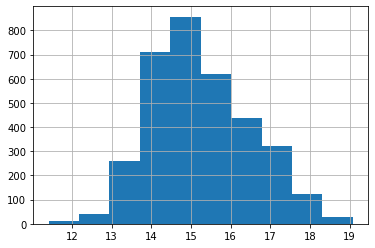

In [5]:
from sklearn.preprocessing import RobustScaler

fields = df.columns
fields = [_f for _f in fields if _f not in ['index', 'id', 'squad' ,'season', 'player', "position", "contract_signing", "league", "value_eur", "wage_eur"]]
fields = [_f for _f in fields if _f not in  ["birth_year", "nationality","overall", "potential", "pace","shooting", "passing", "dribbling", "defending", "physic"]]

# fields = "age,games,minutes,overall,potential,pace,shooting,passing,dribbling,defending,physic,DF,FW,GK,MF,pos_avg"
# fields = fields.rsplit(',')


numeric_data = []
non_numeric_data = []
for col in fields:
    if "L_" in col or "T_" in col or "N_" in col or col in ["GK", "MF", "DF", "FW", "best_age", "rich_team"]:
        non_numeric_data.append(col)
    else:
        numeric_data.append(col)



        
means, maxs, mins, stds = dict(), dict(), dict(), dict()

for col in numeric_data:
    means[col] = df[col].mean()
    maxs[col] = df[col].max()
    mins[col] = df[col].min()
    stds[col] = df[col].std()
for col in numeric_data:
    pass
#     df[col] = (df[col] - mins[col]) / (maxs[col] - mins[col])
#     df[col] = (df[col] - means[col]) / stds[col]

numeric_data.append("value_eur")
# df["value_eur"] = df["value_eur"] / df["value_eur"].median()

# Normalizer = RobustScaler(with_centering = False).fit(
#     df[numeric_data]
# )
df = pd.DataFrame(
    data=np.column_stack([
        df[non_numeric_data],
        df[numeric_data]
#         Normalizer.transform(df[numeric_data])
    ]),
    columns=non_numeric_data + numeric_data
)
df.value_eur.hist()
df

In [6]:
def create_train_validate_test_loader(df, train_percent=.6, validate_percent=.3, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    data_list = [train, validate, test]
    return data_list

data_list = create_train_validate_test_loader(df)
dataloader_list = []
target = "value_eur"
num_feature = data_list[0].shape[1]-1
for data in data_list:
    X = torch.tensor(np.array(data[fields]), dtype=torch.float)
    y = torch.tensor(np.array(data[target]).reshape(-1, 1), dtype=torch.float)
    _dataset = TensorDataset(X,
                             y)
    _loader = DataLoader(_dataset, batch_size=2048)
    dataloader_list.append(_loader)
train_loader, eval_loader, test_loader = dataloader_list

In [7]:
def train(model, lr, epochs, loss_function, device):

    model = model.to(device)
    
    loss_value = []
    eval_loss_value = []
    optimizer = optim.Adam(params = model.parameters(), lr = lr)

    no_improve_counter = 0
    best_eval_loss = np.inf
    best_model = None
    for i in range(epochs):
        for (x, y) in train_loader:
            model.train()
            x = x.to(device)
            # initialize the gradient of model parameters
            optimizer.zero_grad()
            # calculate the loss
            y_pred = model(x)

            loss = loss_function(y_pred, y.to(device))

            loss.backward()

            optimizer.step()
        if (i % 10) == 0:
            model.eval()
            eval_loss = []
            for (x_eval, y_eval) in eval_loader:
                y_eval_pred = model(x_eval.to(device))
                eval_loss.append(loss_function(y_eval_pred, y_eval.to(device)).detach().cpu().numpy())
            eval_loss = np.mean(eval_loss)
            
            print('epoch: {},'.format(i) + 'loss: {:.2e}'.format(loss.detach()) + ', eval_loss: {:.2e}'.format(eval_loss))
            eval_loss_value.append(eval_loss)
            loss_value.append(loss)
            
#             best_eval_loss = np.min(loss_value)
            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss
                best_model = model
                no_improve_counter = 0
            else:
                no_improve_counter += 1

            if no_improve_counter == 30:
                plt.plot((loss_value))
                plt.plot((eval_loss_value))
                print('best_eval_loss: {:.2e}'.format(best_eval_loss))
                return best_model



    plt.plot((loss_value))
    plt.plot((eval_loss_value))

    return best_model




In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.l1 = nn.Linear(num_feature, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 256)
        self.l4 = nn.Linear(256, 256)
        self.l5 = nn.Linear(256, 128)
        self.l6 = nn.Linear(128, 128)
        self.l7 = nn.Linear(128, 64)
        self.l8 = nn.Linear(64, 10)
        
        self.lin1 = nn.Linear(num_feature, 512)
        self.lin2 = nn.Linear(512, 512)
        self.lin3 = nn.Linear(512, 64)
        self.lin4 = nn.Linear(64, 10)
        self.lin5 = nn.Linear(10, 10)
        
#         self.bn0 = nn.BatchNorm1d(157)
#         self.bn1 = nn.BatchNorm1d(160)
#         self.bn2 = nn.BatchNorm1d(40)
#         self.bn3 = nn.BatchNorm1d(20)
#         self.bn4 = nn.BatchNorm1d(10)
        
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.2)
        self.dropout4 = nn.Dropout(0.1)

        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(10, 1)
        
        # Define sigmoid activation and softmax output 
        self.softmax_1 = nn.Softmax(dim=1)
        self.softmax_2 = nn.Softmax(dim=1)
        self.softmax_3 = nn.Softmax(dim=1)
        
        

#         nn.init.xavier_uniform_(self.l1.weight)
#         nn.init.xavier_uniform_(self.l2.weight)
#         nn.init.xavier_uniform_(self.l3.weight)
#         nn.init.xavier_uniform_(self.l4.weight)
#         nn.init.xavier_uniform_(self.l5.weight)
#         nn.init.xavier_uniform_(self.l6.weight)
#         nn.init.xavier_uniform_(self.l7.weight)
#         nn.init.xavier_uniform_(self.l8.weight)
        nn.init.xavier_uniform_(self.lin1.weight)
        nn.init.xavier_uniform_(self.lin2.weight)
        nn.init.xavier_uniform_(self.lin3.weight)
        nn.init.xavier_uniform_(self.lin4.weight)
        nn.init.xavier_uniform_(self.lin5.weight)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
#         x = self.bn0(x)
#         x = self.l1(x)
#         x = self.dropout(x)
#         x = torch.sigmoid(x)
        
#         x = self.l2(x)
#         x = self.dropout(x)
#         x = torch.sigmoid(x)
        
#         x = self.l3(x)
#         x = self.dropout(x)
#         x = torch.sigmoid(x)

#         x = self.l4(x)
#         x = self.dropout(x)
#         x = F.sigmoid(x)
        
#         x = torch.sigmoid(self.l5(x))
#         x = F.sigmoid(self.l6(x))
#         x = torch.sigmoid(self.l7(x))
#         x = self.softmax_1(self.l8(x))
        x = self.lin1(x)
        x = self.dropout1(x)
        x = F.relu(x)
        
        x = self.lin2(x)
        x = self.dropout2(x)        
        x = F.relu(x)
        
        x = self.lin3(x)
        x = self.dropout3(x)
        x = F.relu(x)

        
        x = self.lin4(x)
        x = self.dropout4(x)
        x = F.relu(x)
        
        x = self.lin5(x)
#         x = self.dropout(x)
        x = F.relu(x)

        
        return self.output(x)
  


epoch: 0,loss: 4.58e+02, eval_loss: 2.93e+02
epoch: 10,loss: 9.76e+01, eval_loss: 1.72e+01
epoch: 20,loss: 6.23e+01, eval_loss: 1.35e+01
epoch: 30,loss: 4.61e+01, eval_loss: 1.39e+01
epoch: 40,loss: 3.48e+01, eval_loss: 1.39e+01
epoch: 50,loss: 2.88e+01, eval_loss: 1.39e+01
epoch: 60,loss: 2.34e+01, eval_loss: 1.36e+01
epoch: 70,loss: 2.06e+01, eval_loss: 1.29e+01
epoch: 80,loss: 1.88e+01, eval_loss: 1.21e+01
epoch: 90,loss: 1.89e+01, eval_loss: 1.16e+01
epoch: 100,loss: 1.65e+01, eval_loss: 1.12e+01
epoch: 110,loss: 1.70e+01, eval_loss: 1.12e+01
epoch: 120,loss: 1.62e+01, eval_loss: 1.11e+01
epoch: 130,loss: 1.60e+01, eval_loss: 1.09e+01
epoch: 140,loss: 1.48e+01, eval_loss: 1.07e+01
epoch: 150,loss: 1.38e+01, eval_loss: 1.04e+01
epoch: 160,loss: 1.42e+01, eval_loss: 1.01e+01
epoch: 170,loss: 1.31e+01, eval_loss: 9.72e+00
epoch: 180,loss: 1.26e+01, eval_loss: 9.28e+00
epoch: 190,loss: 1.24e+01, eval_loss: 9.08e+00
epoch: 200,loss: 1.27e+01, eval_loss: 9.05e+00
epoch: 210,loss: 1.26e+0

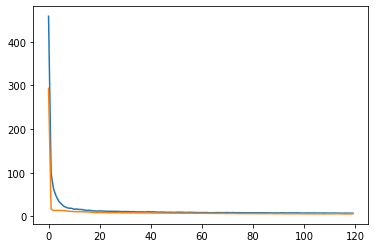

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Network()
loss_function = nn.L1Loss()

model = train(model, 1e-4, 1200, loss_function, device)

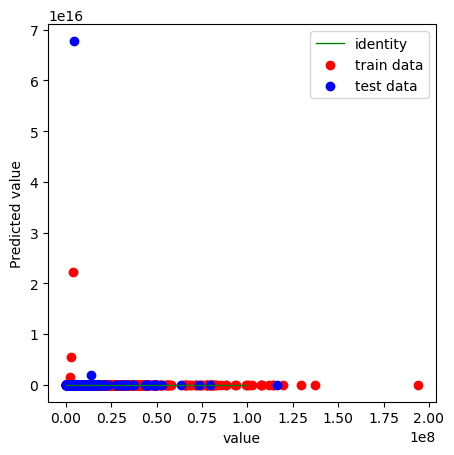

-7.218373644620328e+16

In [10]:
model.eval()
# print(fields)
X_train = torch.tensor(np.array(data_list[0][fields]), dtype=torch.float)
y_train = torch.tensor(np.array(data_list[0][target]).reshape(-1, 1), dtype=torch.float)

X_test = torch.tensor(np.array(data_list[-1][fields]), dtype=torch.float)
y_test = torch.tensor(np.array(data_list[-1][target]).reshape(-1, 1), dtype=torch.float)

y_train_pred = model(X_train.to(device))
y_test_pred = model(X_test.to(device))

# Convert into numpy array
y_train_pred = y_train_pred.detach().cpu().numpy().squeeze()
y_test_pred = y_test_pred.detach().cpu().numpy().squeeze()

# print(y_test.numpy().squeeze())
# print(y_test_pred)

plt.figure(figsize=(5, 5), dpi=100)

plt.xlabel("value")
plt.ylabel("Predicted value")
plt.plot(np.linspace(0,1e8), np.linspace(0,1e8), lw=1, color="g", label="identity")

plt.scatter(np.exp(y_train), np.exp(y_train_pred), lw=1, color="r", label="train data")
plt.scatter(np.exp(y_test), np.exp(y_test_pred), lw=1, color="b", label="test data")
plt.legend()
plt.show()
r2_score(np.exp(y_test.numpy().squeeze()), np.exp(y_test_pred))

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# print(random_grid)
# fields = df.columns
# fields = [_f for _f in fields if _f not in ['index', 'id', 'squad' ,'season', 'player', "position", "contract_signing", "league", "value_eur", "wage_eur"]]

# fields = df.columns
# fields = [_f for _f in fields if _f not in ["season", "player", "contract_signing", "league"]]
# X = df[fields]
# y = df[['value_eur']]
# X.dtypes
# x_trainr, x_testr, y_trainr, y_testr = train_test_split(X, y.squeeze(), random_state=75, test_size=0.3)

regr = RandomForestRegressor()
regr.fit(X_train, y_train.ravel())

RandomForestRegressor()

0.6251722091507237

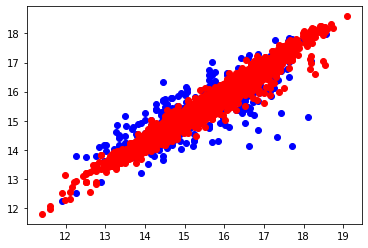

In [12]:
y_train_pred_r = regr.predict(X_train)

y_test_pred_r = regr.predict(X_test)
plt.scatter(y_test, y_test_pred_r, lw=1, color="b", label="test data")
plt.scatter(y_train, y_train_pred_r, lw=1, color="r", label="train data")
r2_score(y_test, y_test_pred_r)


In [13]:
regr.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [14]:
import plotly.express as px
px.scatter(data, x="squad", y="wage_eur",color= "position", hover_data=["player"])


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['GK', 'MF', 'DF', 'FW', 'rich_team', 'best_age', 'age', 'games', 'games_starts', 'minutes', 'goals', 'assists', 'pens_made', 'pens_att', 'cards_yellow', 'cards_red', 'goals_per90', 'assists_per90', 'goals_assists_per90', 'goals_pens_per90', 'goals_assists_pens_per90', 'xg', 'npxg', 'xa', 'xg_per90', 'xa_per90', 'xg_xa_per90', 'npxg_per90', 'npxg_xa_per90', 'minutes_90s', 'shots_total', 'shots_on_target', 'shots_free_kicks', 'shots_on_target_pct', 'shots_total_per90', 'shots_on_target_per90', 'goals_per_shot', 'goals_per_shot_on_target', 'npxg_per_shot', 'xg_net', 'npxg_net', 'passes_completed', 'passes', 'passes_pct', 'passes_total_distance', 'passes_progressive_distance', 'passes_completed_short', 'passes_short', 'passes_pct_short', 'passes_completed_medium', 'passes_medium', 'passes_pct_medium', 'passes_completed_long', 'passes_long', 'passes_pct_long', 'xa_net', 'assisted_shots', 'passes_into_final_third', 'passes_into_penalty_area', 'crosses_into_penalty_area', 'progressive_passes', 'passes_live', 'passes_dead', 'passes_free_kicks', 'through_balls', 'passes_pressure', 'passes_switches', 'crosses', 'corner_kicks', 'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_straight', 'passes_ground', 'passes_low', 'passes_high', 'passes_left_foot', 'passes_right_foot', 'passes_head', 'throw_ins', 'passes_other_body', 'passes_offsides', 'passes_oob', 'passes_intercepted', 'passes_blocked', 'sca', 'sca_per90', 'sca_passes_live', 'sca_passes_dead', 'sca_dribbles', 'sca_shots', 'sca_fouled', 'sca_defense', 'gca', 'gca_per90', 'gca_passes_live', 'gca_passes_dead', 'gca_dribbles', 'gca_shots', 'gca_fouled', 'gca_defense', 'tackles', 'tackles_won', 'tackles_def_3rd', 'tackles_mid_3rd', 'tackles_att_3rd', 'dribble_tackles', 'dribbles_vs', 'dribble_tackles_pct', 'dribbled_past', 'pressures', 'pressure_regains', 'pressure_regain_pct', 'pressures_def_3rd', 'pressures_mid_3rd', 'pressures_att_3rd', 'blocks', 'blocked_shots', 'blocked_shots_saves', 'blocked_passes', 'interceptions', 'clearances', 'errors', 'touches', 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd', 'touches_att_pen_area', 'touches_live_ball', 'dribbles_completed', 'dribbles', 'dribbles_completed_pct', 'players_dribbled_past', 'nutmegs', 'carries', 'carry_distance', 'carry_progressive_distance', 'progressive_carries', 'carries_into_final_third', 'carries_into_penalty_area', 'pass_targets', 'passes_received', 'passes_received_pct', 'miscontrols', 'dispossessed', 'cards_yellow_red', 'fouls', 'fouled', 'offsides', 'pens_won', 'pens_conceded', 'own_goals', 'ball_recoveries', 'aerials_won', 'aerials_lost', 'aerials_won_pct', 'games_subs', 'minutes_per_sub', 'unused_subs', 'points_per_match', 'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90', 'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus', 'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'wc_starts', 'wc_games', 'wc_minutes', 'wc_goals', 'wc_assists', 'wc_cards_yellow', 'wc_cards_red', 'started_ratio', 'dribbles_completed_diff', 'pass_completed_short_ratio', 'pass_completed_medium_ratio', 'value_eur'] but received: squad